In [3]:
import oed_toolbox
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
import plotting_helpers

In [4]:
palette = sns.color_palette()

Create linear model:

In [5]:
K_func = lambda d: -1*(d-1)**2  # jnp.atleast_2d(-1*(d-5)**2 + 20)
b_func = lambda d: 0.2*d**(1/2) + 2
def create_linear_model(K_func, b_func):
    def linear_model(theta, d):
        theta = jnp.atleast_1d(theta.squeeze())
        return K_func(d)*theta + b_func(d)
    return linear_model

In [6]:
prior_mean = jnp.array([1.0])
prior_cov = jnp.identity(1)
noise_cov = 0.1*jnp.identity(1)
model_func = create_linear_model(K_func, b_func)
model_func_dt = jax.jacfwd(model_func, argnums=0)
model = oed_toolbox.models.Model.from_jax_function(model_func)

# Posterior check:

In [7]:
minimizer = oed_toolbox.optim.gradient_descent_for_map()
approx_posterior = \
oed_toolbox.distributions.Posterior.laplace_approximation(model, minimizer, noise_cov, prior_mean, prior_cov)

In [8]:
noise_icov = jnp.linalg.inv(noise_cov)
prior_icov = jnp.linalg.inv(prior_cov)

def logposterior(theta, y, d):
    K = K_func(d)
    b = b_func(d)
    icov = K.T @ noise_icov @ K + prior_icov
    cov = jnp.linalg.inv(icov)
    mean = ((y-b).T @ noise_icov @ K + prior_mean.T @ prior_icov) @ cov
    return jax.scipy.stats.multivariate_normal.logpdf(theta, mean=mean, cov=cov)

true_posterior = \
{'logpdf': jax.vmap(logposterior, in_axes=(0,None,None)),
 'logpdf_dd': jax.vmap(jax.jacfwd(logposterior, argnums=2), in_axes=(0,None,None)), 
 'logpdf_dy': jax.vmap(jax.jacfwd(logposterior, argnums=1), in_axes=(0,None,None))}

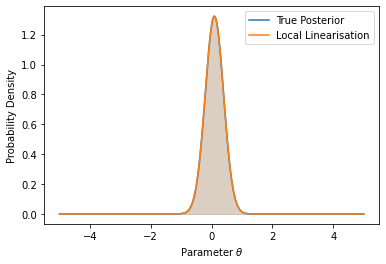

In [35]:
theta_plot = jnp.linspace(-5,5,1000).reshape(-1,1)
y = jnp.array([[2]])
d = jnp.array([[0]])
pdfs = {'True Posterior': jnp.exp(true_posterior['logpdf'](theta_plot, y, d)),
        'Local Linearisation': jnp.exp(approx_posterior.logpdf(theta_plot, y, d)['logpdf'])}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')

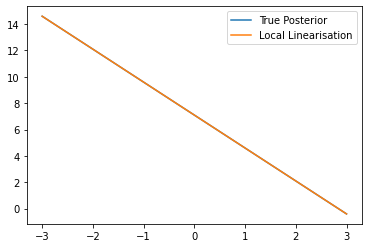

In [68]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
y = jnp.array([[0.8]])
d = jnp.array([[1.5]])
pdfs_dy = {'True Posterior': true_posterior['logpdf_dy'](theta_plot, y, d),
           'Local Linearisation': approx_posterior.logpdf(theta_plot, y, d, return_dy=True)['logpdf_dy']}
fig, ax = plt.subplots()
for i, (key, grad) in enumerate(pdfs_dy.items()):
    sns.lineplot(x=theta_plot.squeeze(), y=grad.squeeze(), color=palette[i], label=key)
plotting_helpers.clean_up_plot(fig)

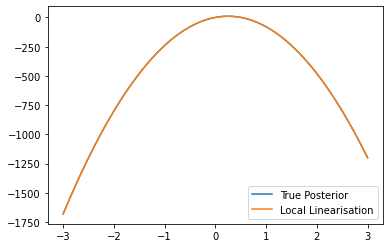

In [72]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
y = jnp.array([[0.4]])
d = jnp.array([[3.]])
pdfs_dd = {'True Posterior': true_posterior['logpdf_dd'](theta_plot, y, d),
           'Local Linearisation': approx_posterior.logpdf(theta_plot, y, d, return_dd=True)['logpdf_dd']}
fig, ax = plt.subplots()
for i, (key, grad) in enumerate(pdfs_dd.items()):
    sns.lineplot(x=theta_plot.squeeze(), y=grad.squeeze(), color=palette[i], label=key)
plotting_helpers.clean_up_plot(fig)

# Ape check:

In [9]:
ape = \
oed_toolbox.losses.APE.using_laplace_approximation(model, \
minimizer, prior_mean,prior_cov, noise_cov, apply_control_variates=False, use_reparameterisation=True)

In [10]:
def ape_func(d):
    K = K_func(d)
    b = b_func(d)
    icov = K * noise_icov * K + prior_icov
    cov = jnp.linalg.inv(icov)
    return 0.5*jnp.log(2*3.1419*cov) + 0.5
true_ape = {'ape': jax.vmap(ape_func, in_axes=0),
            'grad': jax.vmap(jax.jacfwd(ape_func, argnums=0), in_axes=0)}

In [30]:
d_plot = jnp.linspace(0.1, 3, 100)
ape_vals = []
ape_grad_vals = []
for d in d_plot:
    print(d)
    func_returns = ape(d, num_samples=1000)
    ape_vals.append(func_returns[0])
    ape_grad_vals.append(func_returns[1])

0.1
0.12929294
0.15858586
0.18787879
0.21717173
0.24646465
0.27575758
0.30505052
0.33434343
0.36363637
0.39292932
0.42222223
0.45151517
0.48080808
0.510101
0.53939396
0.5686869
0.5979798
0.6272727
0.6565657
0.6858586
0.7151515
0.7444445
0.77373743
0.8030303
0.83232325
0.8616162
0.89090914
0.9202021
0.94949496
0.9787879
1.0080808
1.0373738
1.0666667
1.0959595
1.1252526
1.1545455
1.1838384
1.2131314
1.2424244
1.2717172
1.3010101
1.330303
1.359596
1.388889
1.4181818
1.4474748
1.4767678
1.5060606
1.5353535
1.5646465
1.5939394
1.6232324
1.6525253
1.6818182
1.7111112
1.7404041
1.769697
1.7989899
1.828283
1.8575758
1.8868687
1.9161618
1.9454546
1.9747475
2.0040405
2.0333333
2.0626261
2.0919192
2.1212122
2.150505
2.1797981
2.209091
2.2383838
2.2676768
2.2969697
2.3262627
2.3555558
2.3848486
2.4141414
2.4434345
2.4727273
2.5020201
2.5313132
2.560606
2.589899
2.6191921
2.648485
2.6777778
2.7070708
2.7363636
2.7656565
2.7949498
2.8242426
2.8535354
2.8828285
2.9121213
2.941414
2.9707072
3.0


<AxesSubplot:>

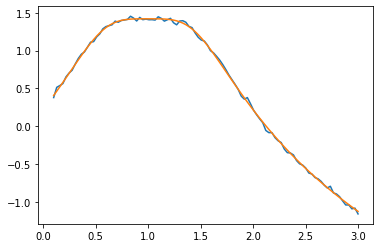

In [31]:
sns.lineplot(x=d_plot, y=ape_vals)
sns.lineplot(x=d_plot, y=true_ape['ape'](d_plot).squeeze())

<AxesSubplot:>

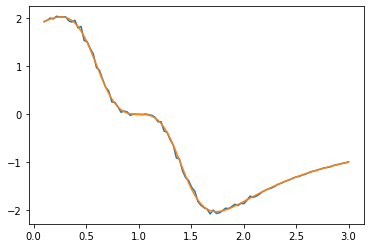

In [35]:
sns.lineplot(x=d_plot, y=np.array(ape_grad_vals).squeeze())
sns.lineplot(x=d_plot, y=true_ape['grad'](d_plot).squeeze())